# 5. Early payment behaviour modelling

### Idea of the model and it's benefit to business
The party who lends the money, earn interest over the time of loan. Early repayment can reduce the expected interest income. By predicting early repayments, lenders can adjust their loan products, pricing strategies, and interest rates to optimize revenue.

Early repayment behavior can sometimes be correlated with credit risk. For instance, borrowers who repay early might be refinancing to take advantage of lower interest rates elsewhere, indicating a competitive risk. Conversely, early repayment can signal improved borrower financial health. Understanding these patterns can refine risk assessment models.

Steps are being very similar to what we have did when predicting default behaviour. Therefore I will comment only the results and parts that are different from previous notebook.

In [1]:
import os
import sys
from pathlib import Path

sys.path.append(str(Path(os.getcwd()).parent.absolute()) + "\\app")

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import lightgbm as lgb
import joblib
import config
import shap
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from hyperopt import hp, space_eval
from hyperopt.pyll.base import scope
from imblearn.under_sampling import RandomUnderSampler
from functions_visualization import plot_precision_recall_and_confusion_matrix, show_fig
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
)

from data_extraction.data_extractor_pipe import (
    DataExtractor,
    SequentialDataPipeline,
    ColumnDropper,
    ContractTypeSelector,
    ScaleMinMax,
    RemoveInf,
    ColumnRenamer,
    CategoricalColsConverter,
    get_preprocessing_pipeline,
)
from data_extraction.scripts import (
    bureau,
    pos_cash,
    instalment_payments,
    credit_card_balance,
    previous_applications,
    application,
)
from functions import (
    train_test_sets,
    load_or_run_rfecv,
    run_hyperopt,
    objective,
    prepare_trials_dataframe,
    add_hover_data,
)

pd.set_option("display.max_columns", None)
%load_ext nb_black

<IPython.core.display.Javascript object>

#### Setting access to reach GCP bucket

In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = config.GOOGLE_APPLICATION_CREDENTIALS

<IPython.core.display.Javascript object>

#### Same pipeline to reach our data

In [4]:
preprocessing_pipeline = get_preprocessing_pipeline(
    application_data="application_train.csv"
)

<IPython.core.display.Javascript object>

In [5]:
X = preprocessing_pipeline.fit_transform(pd.DataFrame())

<IPython.core.display.Javascript object>

#### Top 10 correlations to early repayment behavior

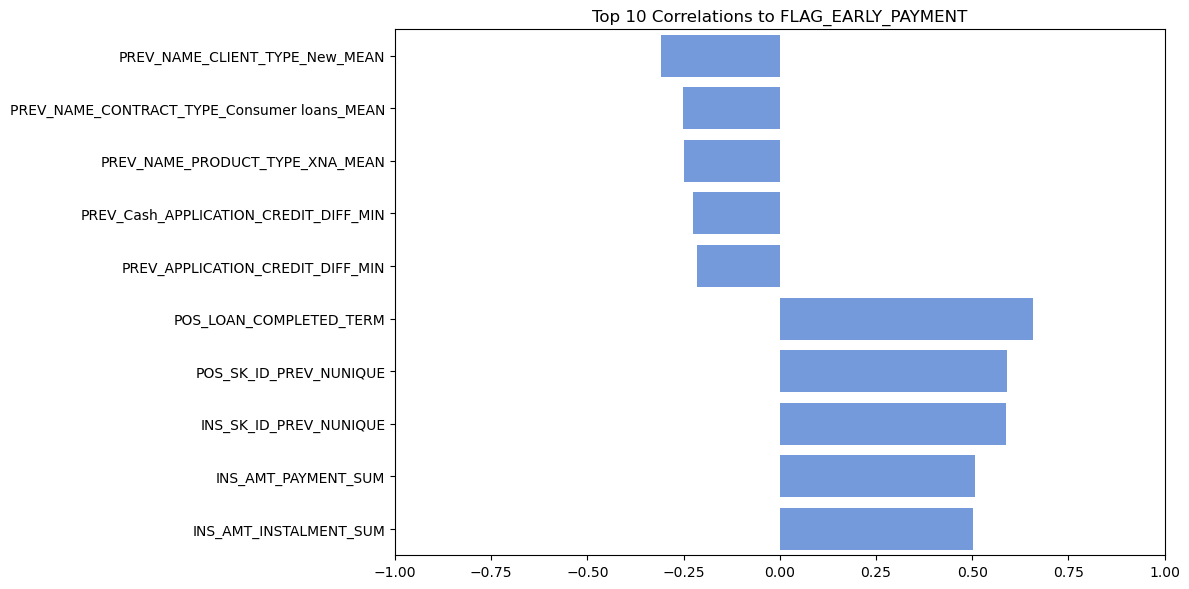

<IPython.core.display.Javascript object>

In [6]:
correlations = pd.Series(index=X.columns, dtype=float)
for col in X.columns:
    if col != "POS_COMPLETED_BEFORE_TERM":
        correlations[col] = X["POS_COMPLETED_BEFORE_TERM"].corr(X[col])

top_corr = correlations.nsmallest(5).append(correlations.nlargest(5))

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_corr.values,
    y=top_corr.index,
    color="cornflowerblue",
)
plt.title("Top 10 Correlations to FLAG_EARLY_PAYMENT")
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

The top positively correlated feature suggests a strong likelihood that new clients are making early payments. The presence of "Consumer loans" in contract type and "XNA" (typically indicating a missing category) in product type also show a positive but weaker correlation with early payment.


Conversely, features like "PREV_Cash_APPLICATION_CREDIT_DIFF_MIN" and "PREV_APPLICATION_CREDIT_DIFF_MIN" have a negative correlation with early payment, indicating that as the difference between the credit amount applied for and the credit amount granted for cash loans decreases, the likelihood of early payment also decreases.


The number of unique installment payments and the total amount paid in installments (both positively correlated) suggest that clients with a higher number of payment instances and those who have paid more in total are more likely to make early payments.

#### Preparing target variable

In [7]:
X["POS_COMPLETED_BEFORE_TERM"].isna().any().sum()

1

<IPython.core.display.Javascript object>

In [8]:
X.dropna(subset=["POS_COMPLETED_BEFORE_TERM"], inplace=True)

<IPython.core.display.Javascript object>

The feature POS_COMPLETED_BEFORE_TERM indicates the number of times a person has paid off their loan early. However, we will perform only a binary classification to identify whether a client exhibits early repayment behavior or not.

- 0: No early repayment behavior
- 1: Early repayment behavior

In [9]:
X["POS_COMPLETED_BEFORE_TERM"].value_counts()

0.0     127767
1.0      84570
2.0      31367
3.0      11778
4.0       4534
5.0       1810
6.0        703
7.0        294
8.0        134
9.0         56
10.0        31
11.0        11
12.0         8
13.0         4
14.0         3
15.0         1
Name: POS_COMPLETED_BEFORE_TERM, dtype: int64

<IPython.core.display.Javascript object>

In [10]:
EARLY_PAYMENT_LEVEL = np.where(X["POS_COMPLETED_BEFORE_TERM"] == 0, 0, 1)

<IPython.core.display.Javascript object>

In [11]:
np.count_nonzero(np.isnan(EARLY_PAYMENT_LEVEL))

0

<IPython.core.display.Javascript object>

In [12]:
X["EARLY_PAYMENT_LEVEL"] = EARLY_PAYMENT_LEVEL

<IPython.core.display.Javascript object>

In [13]:
X.drop(columns="POS_COMPLETED_BEFORE_TERM", inplace=True)

<IPython.core.display.Javascript object>

In [14]:
X_train, X_test, y_train, y_test = train_test_sets(X, "EARLY_PAYMENT_LEVEL")

<IPython.core.display.Javascript object>

In [15]:
X

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DOCUMENT_COUNT,EXT_SOURCE_SUM,AGE_YEARS,AGE_RANGE,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,CREDIT_TO_INCOME_RATIO,INCOME_TO_EMPLOYED_RATIO,INCOME_TO_BIRTH_RATIO,EMPLOYED_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,HOUSE_DATA_MISSING_FLAG,BUREAU_SK_ID_BUREAU_NUNIQUE,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AVAILABLE_CREDIT_MEAN,BUREAU_AVAILABLE_CREDIT_SUM,BUREAU_MONTHS_BALANCE_MEAN_MEAN,BUREAU_MONTHS_BALANCE_SIZE_MEAN,BUREAU_MONTHS_BALANCE_SIZE_SUM,BUREAU_STATUS_0_MEAN,BUREAU_STATUS_1_MEAN,BUREAU_STATUS_LATE_MEAN,BUREAU_STATUS_C_MEAN,BUREAU_STATUS_X_MEAN,BUREAU_CREDIT_ACTIVE_Active_MEAN,BUREAU_CREDIT_ACTIVE_Closed_MEAN,BUREAU_CREDIT_ACTIVE_Sold_MEAN,BUREAU_CREDIT_TYPE_Consumer credit_MEAN,BUREAU_CREDIT_TYPE_Credit card_MEAN,BUREAU_CREDIT_TYPE_Car loan_MEAN,BUREAU_CREDIT_TYPE_Mortgage_MEAN,BUREAU_CREDIT_TYPE_Microloan_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_MAX,BUREAU_ACTIVE_DAYS_CREDIT_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_ACTIVE_DAYS_CREDIT_UPDATE_MIN,BUREAU_ACTIVE_DAYS_CREDIT_UPDATE_MEAN,BUREAU_ACTIVE_USED_CREDIT_PERC_

<IPython.core.display.Javascript object>

In [16]:
y_train.value_counts()

1    121817
0    114946
Name: EARLY_PAYMENT_LEVEL, dtype: int64

<IPython.core.display.Javascript object>

In [17]:
scaler = ScaleMinMax()
modelling_pipeline = Pipeline(
    steps=[
        ("scaler", scaler),
        ("col_renamer", ColumnRenamer()),
    ]
)

<IPython.core.display.Javascript object>

In [18]:
X_train = modelling_pipeline.fit_transform(X=X_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.11, random_state=42
)

X_test = modelling_pipeline.transform(X=X_test)

<IPython.core.display.Javascript object>

In [19]:
scaler.save("early_paymnt_scaler.pkl")

Scaler saved to GCP bucket: <Bucket: loandefault-bckt><Blob: loandefault-bckt, scalers/early_paymnt_scaler.pkl.pkl, 1712563441042852>


<IPython.core.display.Javascript object>

In [20]:
rfecv_early_pymnt = load_or_run_rfecv(
    name="rfecv_early_pymnt",
    classifier=LGBMClassifier(random_state=42, verbose=-1),
    X=X_train,
    y=y_train,
    min_features_to_select=75,
    step=2,
    cv=2,
    scoring="roc_auc",
)

<IPython.core.display.Javascript object>

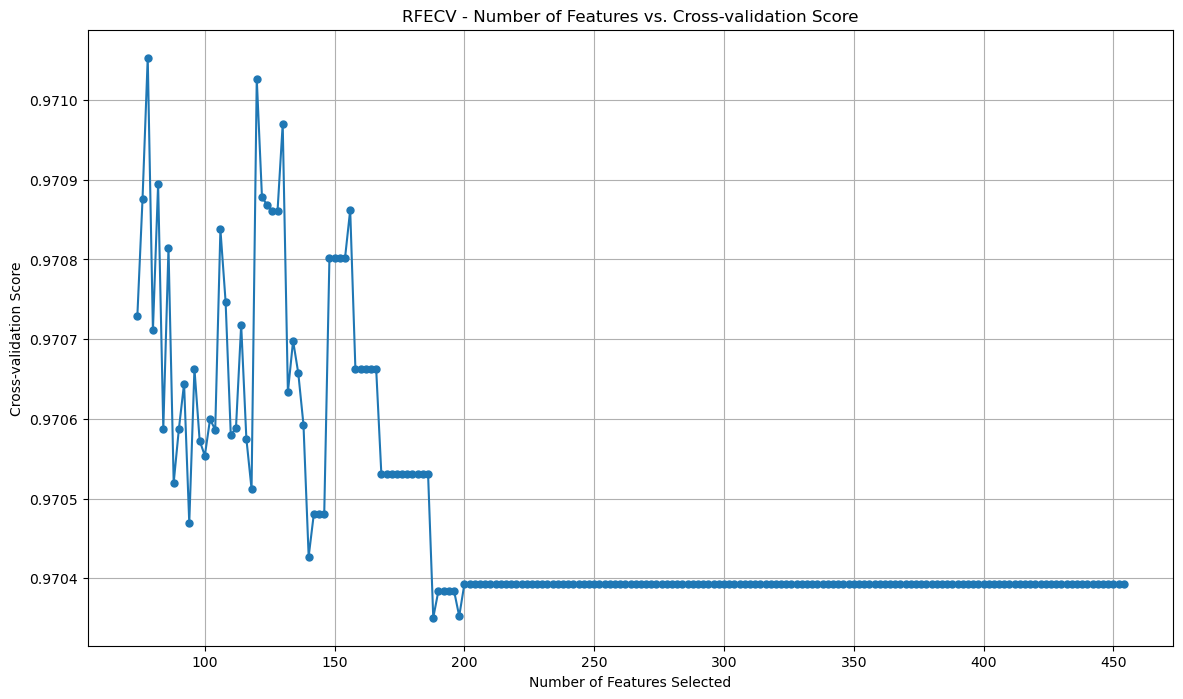

<IPython.core.display.Javascript object>

In [21]:
initial_feature_count = X_train.shape[1]
step = 2 

n_features_evaluated = np.arange(initial_feature_count, 0, -step)[:len(rfecv_early_pymnt.cv_results_['mean_test_score'])][::-1]

plt.figure(figsize=(14, 8))
plt.plot(n_features_evaluated, rfecv_early_pymnt.cv_results_['mean_test_score'], marker='o', linestyle='-', markersize=5)
plt.title("RFECV - Number of Features vs. Cross-validation Score")
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-validation Score")
plt.grid(True)
plt.show()


The cross-validation score appears relatively stable across a wide range of feature quantities, yet there are some fluctuations. Notably, there is no clear upward or downward trend, suggesting that increasing the number of features does not necessarily lead to better predictive performance. 

In [22]:
selected_feature_indices = rfecv_early_pymnt.support_
selected_columns = X_train.loc[:, selected_feature_indices].columns.values
X_train = X_train[selected_columns]
X_val = X_val[selected_columns]
X_test = X_test[selected_columns]

<IPython.core.display.Javascript object>

In [23]:
search_space_early = {
    "model": hp.choice(
        "model",
        [
            {
                "type": "lightgbm",
                "params": {
                    "learning_rate": hp.uniform("lgbm_learning_rate", 0.01, 1),
                    "num_leaves": scope.int(hp.quniform("lgbm_num_leaves", 30, 100, 5)),
                    "n_estimators": scope.int(
                        hp.quniform("lgbm_n_estimators", 25, 1525, 50)
                    ),
                    "max_depth": scope.int(hp.quniform("lgbm_max_depth", 3, 12, 1)),
                    "subsample": hp.uniform("lgbm_subsample", 0.5, 1.0),
                    "colsample_bytree": hp.uniform("lgbm_colsample_bytree", 0.5, 1.0),
                },
            },
            {
                "type": "xgboost",
                "params": {
                    "n_estimators": scope.int(
                        hp.quniform("xgb_n_estimators", 25, 1525, 50)
                    ),
                    "max_depth": scope.int(hp.quniform("xgb_max_depth", 3, 12, 1)),
                    "learning_rate": hp.uniform("xgb_learning_rate", 0.01, 0.3),
                    "subsample": hp.uniform("xgb_subsample", 0.5, 1.0),
                    "colsample_bytree": hp.uniform("xgb_colsample_bytree", 0.5, 1.0),
                    "gamma": hp.uniform("xgb_gamma", 0, 0.5),
                },
            },
        ],
    ),
}

<IPython.core.display.Javascript object>

In [24]:
best_early_flag, trials_early_flag = run_hyperopt(
    "early_payment",
    objective,
    search_space_early,
    X_train,
    y_train,
    X_val,
    y_val,
    max_evals=200,
    seed=42,
    n_early_stop=60,
    scoring="roc_auc",
)

Loading trials and best parameters from GCS.


<IPython.core.display.Javascript object>

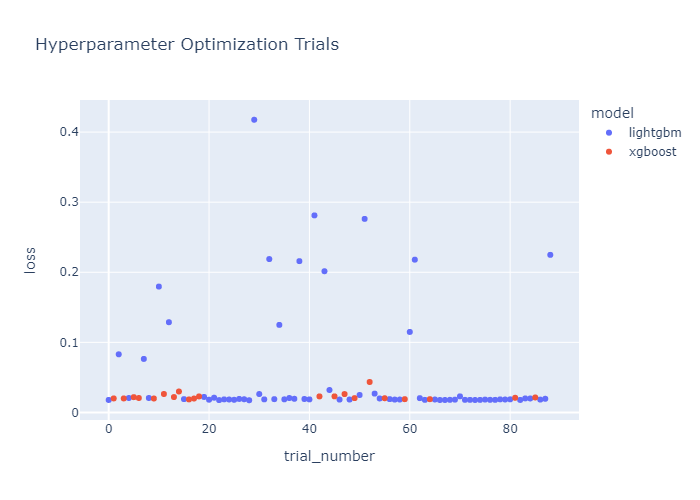

<IPython.core.display.Javascript object>

In [25]:
trials_df = prepare_trials_dataframe(trials_early_flag)

fig = px.scatter(
    trials_df,
    x="trial_number",
    y="loss",
    color="model",
    title="Hyperparameter Optimization Trials",
    labels={"x": "Trial Number", "y": "Recall"},
)


fig = add_hover_data(fig, trials_df, "lightgbm")
fig = add_hover_data(fig, trials_df, "xgboost")

show_fig(fig, render="image")

In [26]:
best_param_lgbm = space_eval(search_space_early, best_early_flag)["model"]["params"]
model_lgbm = LGBMClassifier(**best_param_lgbm, random_state=42, verbose=-1)
model_lgbm.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.6856852256135625,
               learning_rate=0.13850850483300547, max_depth=9,
               n_estimators=1300, num_leaves=90, random_state=42,
               subsample=0.8098553120955023, verbose=-1)

<IPython.core.display.Javascript object>

In [27]:
y_pred = model_lgbm.predict(X_test)
y_pred_proba = model_lgbm.predict_proba(X_test)[:, 1]
print("LGBM Classifier Performance:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba, multi_class="ovo"))

LGBM Classifier Performance:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     12821
           1       0.92      0.94      0.93     13487

    accuracy                           0.93     26308
   macro avg       0.93      0.93      0.93     26308
weighted avg       0.93      0.93      0.93     26308

ROC AUC: 0.9830918653162656


<IPython.core.display.Javascript object>

The LGBM Classifier shows excellent performance with precision, recall, and F1-scores all above 0.90, indicating a strong ability to correctly classify both positive and negative cases. With an overall accuracy of 93% and an outstanding ROC AUC of 0.983, the model demonstrates exceptional predictive power and reliability in distinguishing between classes.

In [28]:
shap_values = shap.TreeExplainer(model_lgbm).shap_values(X_test)

C:\Users\matas\anaconda3\lib\site-packages\shap\explainers\_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



<IPython.core.display.Javascript object>

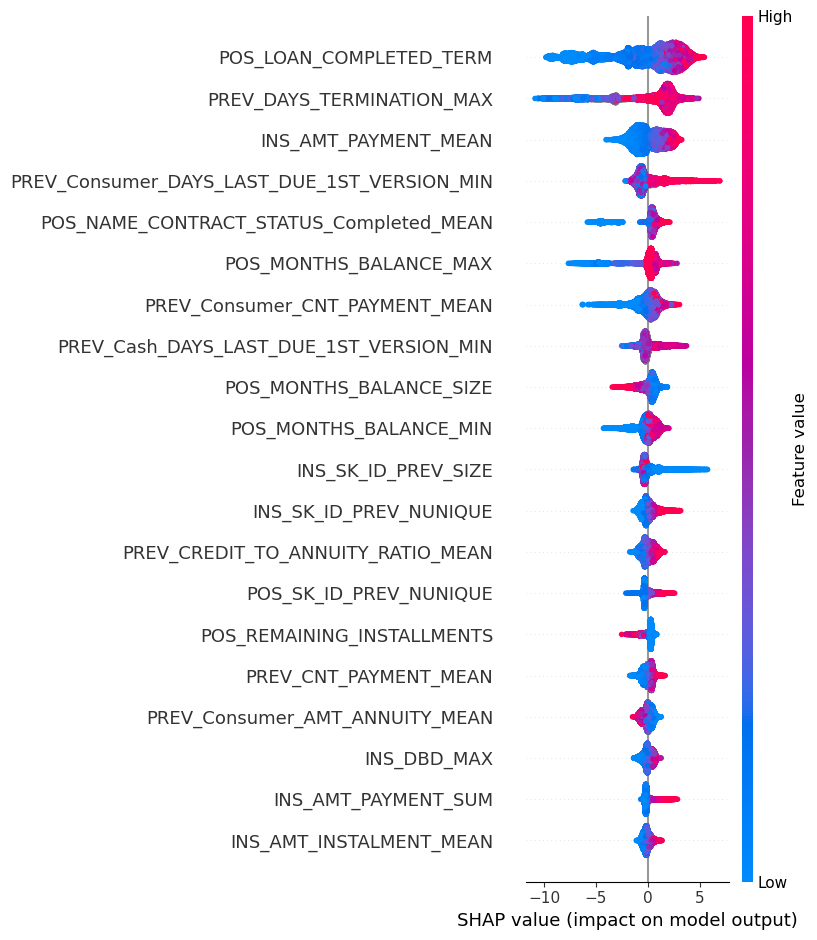

<IPython.core.display.Javascript object>

In [29]:
shap.summary_plot(shap_values, X_test)

The SHAP summary plot indicates that features like POS_LOAN_COMPLETED_TERM and PREV_DAYS_TERMINATION_MAX are among the most influential, with wide-ranging effects on the model's predictions. High feature values, especially in variables like POS_MONTHS_BALANCE_MAX, tend to increase the predicted outcome, while others like INS_AMT_PAYMENT_MEAN are associated with decreasing it. This underscores the nuanced interplay between feature values and their impact on model behavior.


Before we conclude, let's quickly check the direct correlation score for the number of days a person takes to make a decision:

In [30]:
correlations["PREV_DAYS_DECISION_MEAN"]

0.11879336001603838

<IPython.core.display.Javascript object>

A slight positive correlation suggests that individuals who take more time to decide on a loan tend to repay it earlier. This insight indicates that these individuals approach loans more cautiously, taking time to consider their options. If feasible, they may opt to repay the loan sooner to alleviate financial burdens.

### Final conclusions overall and what could be better?

Reflecting on the project, I recognize several areas for potential improvement. Firstly, I aimed to work extensively with original data, minimizing the removal of features or rows with missing values. However, this approach may have limited the model's performance, as incomplete applications are common and imputing a large amount of data could artificially inflate features. In hindsight, a cleaner dataset with imputed values and a model trained on outlier-free data might have yielded better results.

Additionally, I acknowledge the potential for more in-depth analysis post-feature engineering, including the exploration of various charts for Exploratory Data Analysis (EDA) and the application of different statistical tests to gain deeper insights.

Furthermore, I acknowledge the need for further improvement of my FastAPI application, particularly in terms of enhancing the interface and providing more interpretable output for end-users.

#### Saving model

In [31]:
from google.cloud import storage
from io import BytesIO

storage_client = storage.Client()
bucket = storage_client.bucket(config.BUCKET_NAME)
blob = bucket.blob(f"{config.MODELS_FOLDER}early_payment_model_lgb.pkl")

if not blob.exists():
    byte_stream = BytesIO()
    joblib.dump(model_lgbm, byte_stream)
    byte_stream.seek(0)
    blob.upload_from_file(byte_stream, content_type="application/octet-stream")
    print(f"Model saved to GCP bucket: {blob}")

<IPython.core.display.Javascript object>